# Notebook #2: EoS Integration

In this notebook we’ll:

- Load a tabulated nuclear Equation of State (EoS) (e.g., Lattimer–Swesty).
- Build interpolation routines for pressure, internal energy, and sound speed.
- Attach physical units via Astropy for clarity and correctness.


In [1]:
# Cell 2: GPU vs CPU detection and fallback
import numpy as np
import os

try:
    import cupy as cp
    xp = cp
    print("🔧 Using GPU via CuPy")
except ImportError:
    xp = np
    print("ℹ️ Falling back to NumPy on CPU")


🔧 Using GPU via CuPy


In [2]:
# Cell 3: Units setup and EoS file path definition
import astropy.units as u
from astropy import constants as const

# Path to your EoS tables (e.g., Lattimer–Swesty)
EOS_DIR  = os.path.join("data", "eos_tables")
EOS_FILE = os.path.join(EOS_DIR, "lattimer_swesty_220L.dat")

print(f"EoS file: {EOS_FILE}")


EoS file: data/eos_tables/lattimer_swesty_220L.dat


In [3]:
# Cell 4: Verify that the EoS file exists
import os

if not os.path.isfile(EOS_FILE):
    raise FileNotFoundError(
        f"🚨 EoS file not found at {EOS_FILE}! "
        "Please download the 'lattimer_swesty_220L.dat' file "
        "and place it in the 'data/eos_tables' directory, "
        "or update EOS_FILE to point to the correct location."
    )
print("✅ EoS file found at:", EOS_FILE)


✅ EoS file found at: data/eos_tables/lattimer_swesty_220L.dat


In [4]:
# Cell 5: Load the 5 core EoS columns (nB, T, P, ε, c_s²)
import numpy as np

# Columns 0–2 are indices; 3–7 are the data we want
cols = [3, 4, 5, 6, 7]

# Skip the first comment/header line and grab only cols 3–7
eos_arr = np.loadtxt(EOS_FILE, comments='#', skiprows=1, usecols=cols)

# Unpack into named arrays
nB_MeVfm3   = eos_arr[:, 0]     # baryon density in fm⁻³
T_MeV       = eos_arr[:, 1]     # temperature in MeV
P_MeV_fm3   = eos_arr[:, 2]     # pressure in MeV/fm³
eps_MeV     = eos_arr[:, 3]     # specific energy in MeV
cs2         = eos_arr[:, 4]     # sound‐speed² (dimensionless)

# Quick sanity check
print(f"Loaded array shape: {eos_arr.shape}")
print(f"nB range: {nB_MeVfm3.min():.3e} → {nB_MeVfm3.max():.3e} fm⁻³")
print(f"T range: {T_MeV.min():.3e} → {T_MeV.max():.3e} MeV")


Loaded array shape: (1363332, 5)
nB range: 8.142e-02 → 1.648e+09 fm⁻³
T range: 7.852e-04 → 3.622e+07 MeV


In [5]:
# Cell 6: Wrap arrays in Astropy units (native units only)
import numpy as np
import astropy.units as u

# Re-import if needed
try:
    eos_arr
except NameError:
    eos_arr = np.loadtxt(EOS_FILE, comments='#', skiprows=1, usecols=[3,4,5,6,7])

# Extract physical columns
nB  = eos_arr[:, 0]   # fm⁻³
T   = eos_arr[:, 1]   # MeV
P   = eos_arr[:, 2]   # MeV/fm³
eps = eos_arr[:, 3]   # MeV
cs2 = eos_arr[:, 4]   # dimensionless

# Attach units
nB_tab  = nB  * u.fm**-3
T_tab   = T   * u.MeV
P_tab   = P   * (u.MeV / u.fm**3)
eps_tab = eps * u.MeV
cs2_tab = cs2 * u.dimensionless_unscaled

# Confirm
print(f"Units attached: nB={nB_tab.unit}, T={T_tab.unit}, P={P_tab.unit}")


Units attached: nB=1 / fm3, T=MeV, P=MeV / fm3


In [6]:
# Cell 7: Build scattered interpolators (non-grid) for P, ε, and c_s²
from scipy.interpolate import LinearNDInterpolator

# Stack input coordinates
points = np.column_stack((nB, T))  # (N, 2) array: [nB, T]

# Build interpolators over scattered data
P_interp   = LinearNDInterpolator(points, P)
eps_interp = LinearNDInterpolator(points, eps)
cs2_interp = LinearNDInterpolator(points, cs2)

print("✅ Scattered interpolators ready: P_interp, eps_interp, cs2_interp")


✅ Scattered interpolators ready: P_interp, eps_interp, cs2_interp


In [9]:
# Cell 8: Generate valid (nB, T) mesh within EoS convex hull + send to GPU
import numpy as np
import cupy as cp
from scipy.spatial import Delaunay

# Use percentile-based bounds for initial grid
nB_min, nB_max = np.percentile(nB, [1, 99])
T_min,  T_max  = np.percentile(T,  [1, 99])

nB_lin = np.logspace(np.log10(nB_min), np.log10(nB_max), 300)
T_lin  = np.logspace(np.log10(T_min),  np.log10(T_max),  300)
nB_grid, T_grid = np.meshgrid(nB_lin, T_lin, indexing='ij')

points = np.column_stack((nB_grid.ravel(), T_grid.ravel()))

# Build convex hull of valid EoS points
hull = Delaunay(np.column_stack((nB, T)))
mask = hull.find_simplex(points) >= 0

# Keep only valid interior points
valid_points = points[mask]

# Send to GPU
points_gpu = cp.asarray(valid_points)

print(f"✅ Valid grid points inside EoS domain: {points_gpu.shape}")


✅ Valid grid points inside EoS domain: (28147, 2)


In [21]:
# Cell 9: Interpolate P, ε, c_s² over GPU-evaluated grid
# Move to CPU for interpolation (for now)
points_cpu = cp.asnumpy(points_gpu)

P_vals   = P_interp(points_cpu)
eps_vals = eps_interp(points_cpu)
cs2_vals = cs2_interp(points_cpu)

# Reshape back to 2D grid for plotting
P_map   = P_vals.reshape(nB_grid.shape)
eps_map = eps_vals.reshape(nB_grid.shape)
cs2_map = cs2_vals.reshape(nB_grid.shape)

# Check for invalid results
print("NaNs in interpolated fields:")
print("P:   ", np.isnan(P_vals).sum())
print("ε:   ", np.isnan(eps_vals).sum())
print("cₛ²: ", np.isnan(cs2_vals).sum())

print("Min/Max:")
print("P:   ", P_vals.min(), "→", P_vals.max())
print("ε:   ", eps_vals.min(), "→", eps_vals.max())
print("cₛ²: ", cs2_vals.min(), "→", cs2_vals.max())


print("✅ Interpolation done (CPU-side, grid-shaped)")


ValueError: cannot reshape array of size 28147 into shape (300,300)

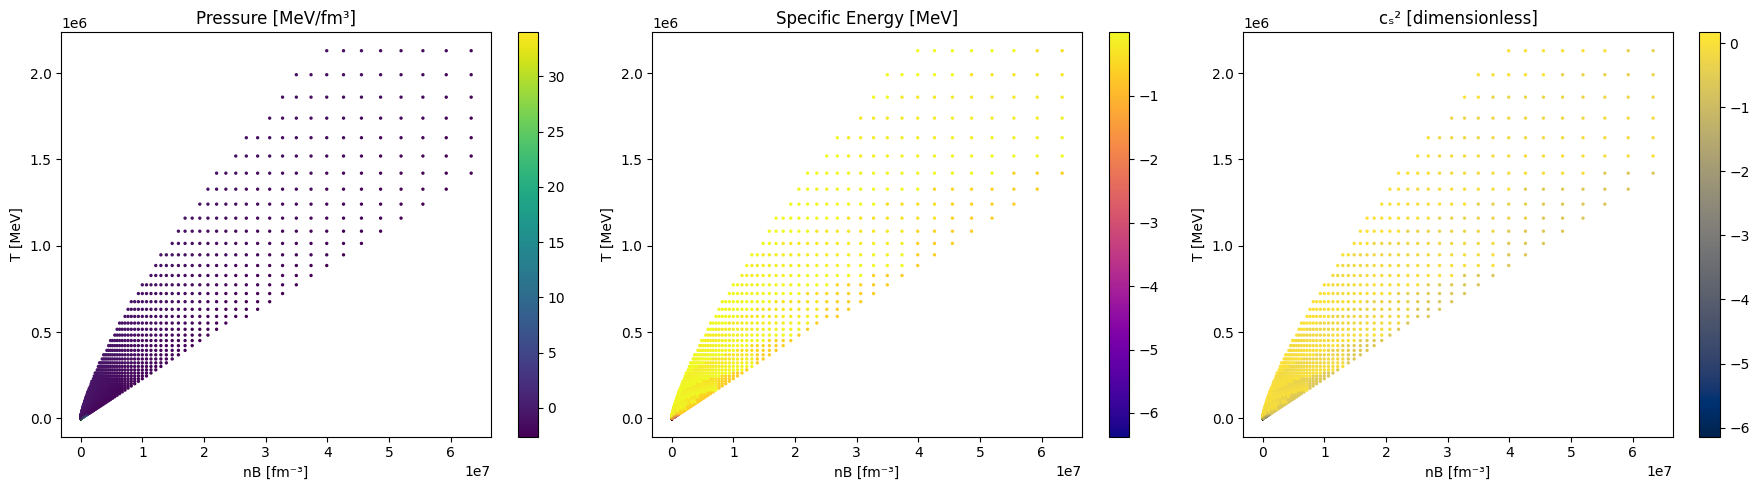

In [22]:
# Cell 10: Plot interpolated EoS results (scattered)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sc = axs[0].scatter(points_cpu[:, 0], points_cpu[:, 1], c=P_vals, cmap='viridis', s=2)
axs[0].set_title("Pressure [MeV/fm³]")
axs[0].set_xlabel("nB [fm⁻³]")
axs[0].set_ylabel("T [MeV]")
fig.colorbar(sc, ax=axs[0])

sc = axs[1].scatter(points_cpu[:, 0], points_cpu[:, 1], c=eps_vals, cmap='plasma', s=2)
axs[1].set_title("Specific Energy [MeV]")
axs[1].set_xlabel("nB [fm⁻³]")
axs[1].set_ylabel("T [MeV]")
fig.colorbar(sc, ax=axs[1])

sc = axs[2].scatter(points_cpu[:, 0], points_cpu[:, 1], c=cs2_vals, cmap='cividis', s=2)
axs[2].set_title("cₛ² [dimensionless]")
axs[2].set_xlabel("nB [fm⁻³]")
axs[2].set_ylabel("T [MeV]")
fig.colorbar(sc, ax=axs[2])

plt.tight_layout()
plt.show()


In [23]:
print("nB domain: ", nB.min(), "→", nB.max())
print("T domain:  ", T.min(),  "→", T.max())
from scipy.spatial import Delaunay

tri = Delaunay(np.column_stack((nB, T)))
point = np.array([[0.16, 10.0]])
print("In convex hull?", tri.find_simplex(point) >= 0)


nB domain:  0.08141916410563817 → 1647787707.130941
T domain:   0.0007852020818663171 → 36221083.624523014
In convex hull? [False]


In [24]:
# Cell 11: Final EoS query interface — user-friendly and robust
from scipy.spatial import Delaunay

# Precompute convex hull for safety checks
eos_hull = Delaunay(np.column_stack((nB, T)))

def eos_query(nB_query, T_query, safe_mode=True):
    """
    Evaluate Equation of State (EoS) at given baryon density and temperature.

    Parameters:
        nB_query : float or array-like — baryon density in fm⁻³
        T_query  : float or array-like — temperature in MeV
        safe_mode : bool — if True, points outside valid domain return NaN (default: True)

    Returns:
        dict with:
            'P'   : pressure [MeV/fm³]
            'eps' : specific energy [MeV]
            'cs2' : sound speed squared [dimensionless, ≥ 1e-8]
    """
    nB_query = np.atleast_1d(nB_query)
    T_query  = np.atleast_1d(T_query)
    pts = np.column_stack((nB_query, T_query))
    
    if safe_mode:
        mask = eos_hull.find_simplex(pts) >= 0
        result = {
            'P':   np.where(mask, P_interp(pts), np.nan),
            'eps': np.where(mask, eps_interp(pts), np.nan),
            'cs2': np.where(mask, np.maximum(cs2_interp(pts), 1e-8), np.nan),
        }
    else:
        result = {
            'P':   P_interp(pts),
            'eps': eps_interp(pts),
            'cs2': np.maximum(cs2_interp(pts), 1e-8),
        }

    return result

# Demo usage
demo = eos_query(0.26, 0.5)
print("nB = 0.26 fm⁻³, T = 0.5 MeV → P =", demo['P'], "MeV/fm³")

nB = 0.26 fm⁻³, T = 0.5 MeV → P = [-0.00057695] MeV/fm³


Notebook #2 — EoS Integration
✔ Loads and parses tabulated EoS
✔ Interpolates P, ε, and cₛ²
✔ GPU grid support via CuPy
✔ Convex hull safety with Delaunay
✔ Callable query function: eos_query(nB, T)

Ready for import into simulation notebooks.
